## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [38]:
!pip install nlp

In [39]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.13.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [40]:
!pip install datasets

In [41]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [43]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [44]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  lables = [x['label'] for x in data]
  return tweets,lables

In [45]:
tweets,lables = get_tweet(train)
tweets[0],lables[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [47]:
tokenizer =Tokenizer(num_words=10000,oov_token='<ukn>')
tokenizer.fit_on_texts(tweets)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

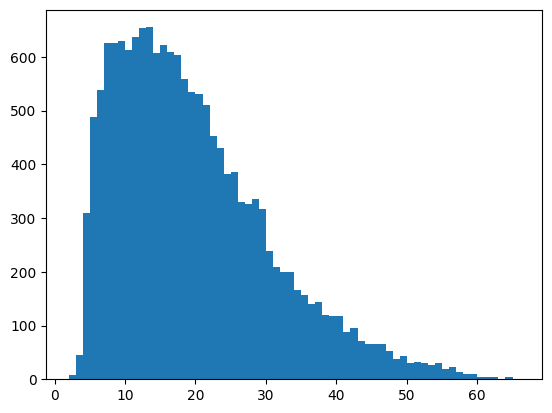

In [48]:
lengths= [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [49]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded= pad_sequences(sequences, truncating='post',padding='post',maxlen=maxlen)
  return padded

In [51]:
padded_train_sequence=get_sequences(tokenizer,tweets)

In [52]:
padded_train_sequence[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [103]:
classes=set(lables)
print(classes)

{0, 1, 2, 3, 4, 5}


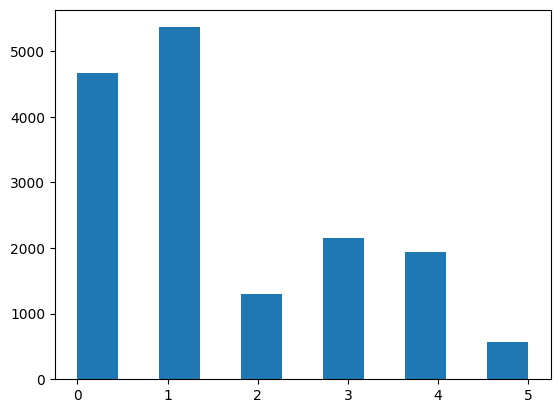

In [54]:
plt.hist(lables,bins=11)
plt.show()

In [83]:
class_to_index={'sadness':0,'joy':1,'love':2,'anger':3,'fear':4,'surprise':5}
index_to_class=dict((k,v) for v,k in class_to_index.items())

In [84]:
class_to_index


{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [86]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [58]:
names_to_ids = lambda lables:np.array([class_to_index.get(x) for x in lables])

In [59]:
train_lables=np.array(lables)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [60]:
model=tf.keras.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [62]:
val_tweets,val_lables = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_lables=np.array(val_lables)

In [63]:
val_tweets[0],val_lables[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [64]:
h= model.fit(
    padded_train_sequence,train_lables,
    validation_data = (val_seq,val_lables),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
        #stops epoch if no improvement in 2 consecutive epochs
    ]
)

Epoch 1/20
500/500 [==============================] - 46s 72ms/step - loss: 1.3094 - accuracy: 0.4664 - val_loss: 0.8320 - val_accuracy: 0.6810
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.6176 - accuracy: 0.7536 - val_loss: 0.6755 - val_accuracy: 0.7590
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4075 - accuracy: 0.8509 - val_loss: 0.5071 - val_accuracy: 0.8520
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2603 - accuracy: 0.9164 - val_loss: 0.4871 - val_accuracy: 0.8550
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1869 - accuracy: 0.9414 - val_loss: 0.3757 - val_accuracy: 0.8830
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1376 - accuracy: 0.9581 - val_loss: 0.4576 - val_accuracy: 0.8705
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1144 - accuracy: 0.9656 - val_loss: 0.4085 - val_accuracy: 0.886

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

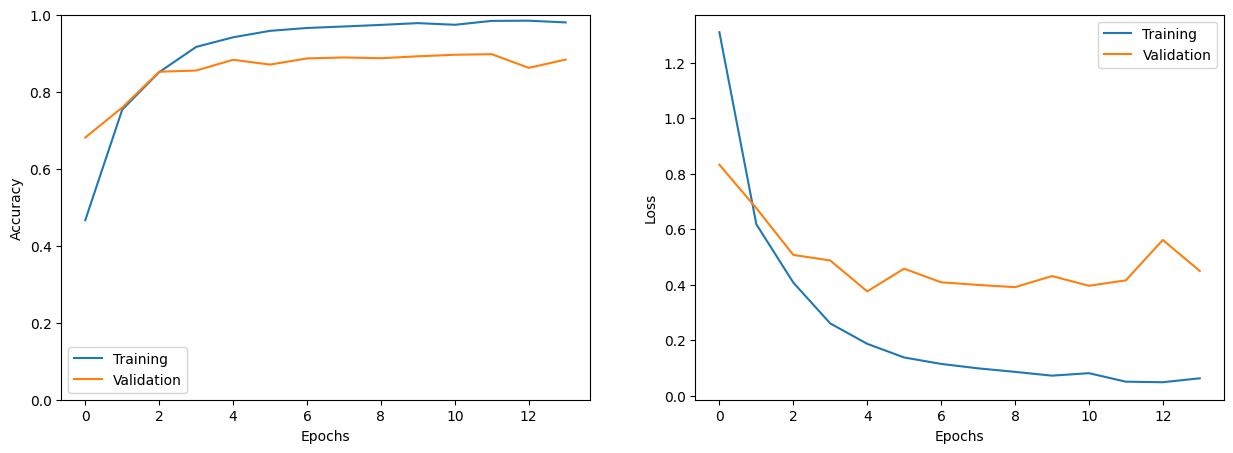

In [65]:
show_history(h)

In [66]:
test_tweets,test_lables = get_tweet(test)
test_seq= get_sequences(tokenizer,test_tweets)
test_lables= np.array(test_lables)

In [67]:
_ = model.evaluate(test_seq,test_lables)

63/63 [==============================] - 1s 8ms/step - loss: 0.4452 - accuracy: 0.8800


In [73]:
i=random.randint(0,len(test_lables)-1)

print('sentence = ',test_tweets[i])
print('Emotion = ',index_to_class[test_lables[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class= index_to_class[np.argmax(p).astype('uint8')]

print('Predicted class = ',pred_class)

sentence =  i usually like sam but sometimes he gets downright whiny and i ll admit that all the mistakes he made due to sibling rivalry and pride that eventually led to the end of season kind of made me feel less tragic about the whole thing
Emotion =  sadness
1/1 [==============================] - 0s 24ms/step
Predicted class =  sadness


In [112]:
predict_x=model.predict(test_seq)
preds=np.argmax(predict_x,axis=1)

63/63 [==============================] - 0s 7ms/step


In [117]:
classes= list(class_to_index.keys())

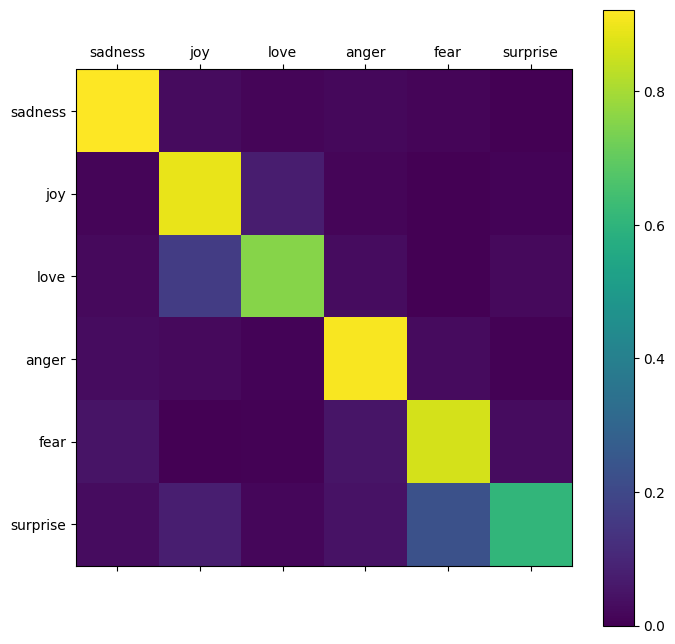

In [118]:
show_confusion_matrix(test_lables, preds,list(classes))